<a href="https://colab.research.google.com/github/ivelten/monte-carlo-samples/blob/master/apple_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
# Importando bibliotecas necessárias.
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas
from pandas_datareader import data as pdr
import yfinance as yfin
yfin.pdr_override()

In [41]:
# Primeiro, fazemos o download de dados de ações históricas da Apple.
apple = pdr.get_data_yahoo('AAPL', start = '2022-01-01')
apple.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-01-03,177.830002,182.880005,177.710007,182.009995,180.190964,104487900
2022-01-04,182.630005,182.940002,179.119995,179.699997,177.904053,99310400
2022-01-05,179.610001,180.169998,174.639999,174.919998,173.171844,94537600
2022-01-06,172.699997,175.300003,171.639999,172.000000,170.280991,96904000
2022-01-07,172.889999,174.139999,171.029999,172.169998,170.449310,86709100


In [42]:
# Em seguida, calculamos o número de dias no espaço de tempo utilizado.
time_elapsed = (apple.index[-1] - apple.index[0]).days

In [43]:
# Agora vamos alimentar os dados para fazer a simulação.
# Vamos fazer o cálculo da taxa composta de crescimento ao longo deste conjunto
# de dados (incluindo o desvio padrão).

# Preço atual / primeiro registro (neste exemplo, preço no início de 2022)
# Este dado nos proverá o percentual do crescimento total.
total_growth = (apple['Adj Close'][-1] / apple['Adj Close'][1])

# Agora vamos anualizar esta porcentagem.
# Primeiro, vamos converter nosso tempo decorrido para a quantidade de anos
number_of_years = time_elapsed / 365.0

# Em seguida, podemos elevar o crescimento total para o inverso da quantidade
# de anos decorridos.
cagr = total_growth ** (1/number_of_years) - 1

# Agora com a taxa média de crescimento anual, também precisamos calcular o
# desvio padrão das alterações diárias de preços.
std_dev = apple['Adj Close'].pct_change().std()

# Como há cerca de 252 dias de negociação em um ano, nós precisamos dimensionar
# isso por um fator de anualização. Referência:
# https://www.fool.com/knowledge-center/how-to-calculate-annualized-volatility.aspx
number_of_trading_days = 252
std_dev = std_dev * math.sqrt(number_of_trading_days)

# Agora nós temos as duas entradas necessárias para gerar dados aleatórios
# para nossa simulação.
print ("cagr (mean returns): ", str(round(cagr,4)))
print ("std_dev (standard deviation of return): ", str(round(std_dev,4)))

cagr (mean returns):  -0.0154
std_dev (standard deviation of return):  0.301


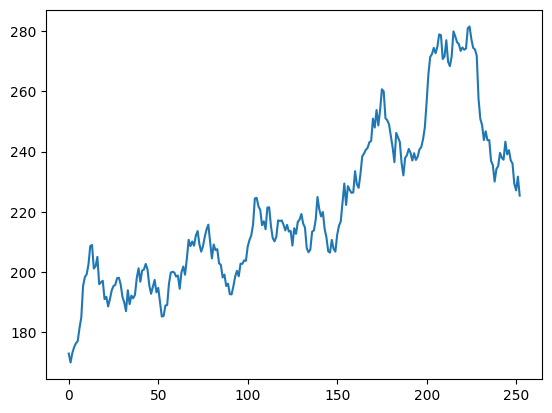

In [44]:
# Gerando valores aleatórios para 1 ano de negociação (252 dias), usando
# a biblioteca numpy e assumindo uma distribuição normal.
daily_return_percentages = np.random.normal(
    cagr / number_of_trading_days,
    std_dev / math.sqrt(number_of_trading_days),
    number_of_trading_days) + 1

# Agora que temos uma série aleatória de futuras porcentagens de retorno
# diárias, podemos aplicar essas previsões para nosso último preço de ação
# na janela, efetivamente levando a previsão de preço para o próximo ano.
# Esta distribuição é conhecida como teoria do passeio aleatório.
price_series = [apple['Adj Close'][-1]]

# Estipulando o preço para o próximo ano...
for j in daily_return_percentages:
    price_series.append(price_series[-1] * j)

# Vamos "plotar" um único passeio aleatório dos nossos preços de ações.
plt.plot(price_series)
plt.show()

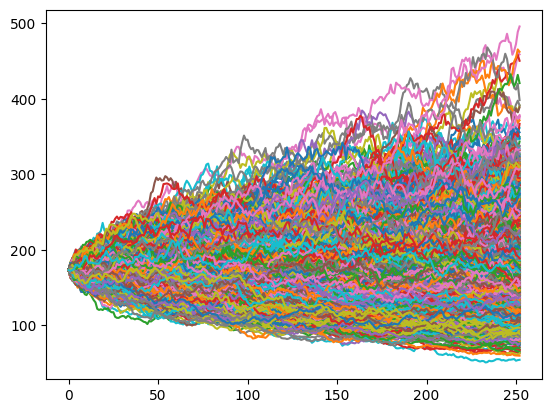

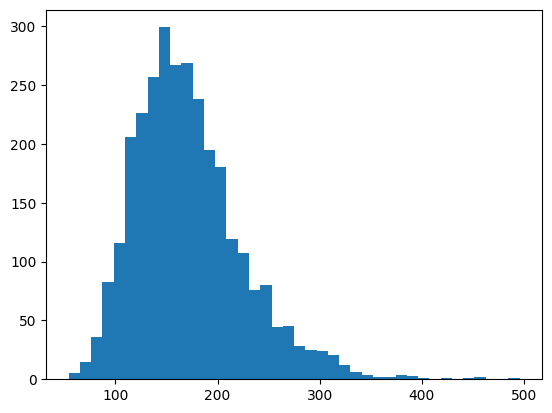

In [46]:
# Agora que o passeio aleatório foi criado, podemos simular o processo com
# uma amostra grande para obter uma noção melhor da distribuição esperada.
number_of_trials = 3000

# Vamos criar um array adicional para coletar todos os preços possíveis de
# fechamento do último dia da janela. Podemos colocar isso num histograma
# para ter uma noção mais clara dos resultados possíveis.
closing_prices = []

for i in range(number_of_trials):
  #Repetindo a lógica usada para ensaiar um passeio aleatório.
  daily_return_percentages = np.random.normal(
      cagr / number_of_trading_days,
      std_dev / math.sqrt(number_of_trading_days),
      number_of_trading_days ) + 1
  price_series = [apple['Adj Close'][-1]]
  for j in daily_return_percentages:
    price_series.append(price_series[-1] * j)
  # Guardando os preços de fechamento do último dia da janela para o histograma.
  closing_prices.append(price_series[-1])
  # "Plotando" os passeios aleatórios.
  plt.plot(price_series)

plt.show()

# "Plotando" o histograma.
plt.hist(closing_prices, bins = 40)
plt.show()

In [47]:
# A partir daqui, podemos verificar a média de todo os preços finais,
# permitindo-nos chegar ao ponto final mais provável.
mean_end_price = round(np.mean(closing_prices),2)
print("Expected price: ", str(mean_end_price))

Expected price:  171.58


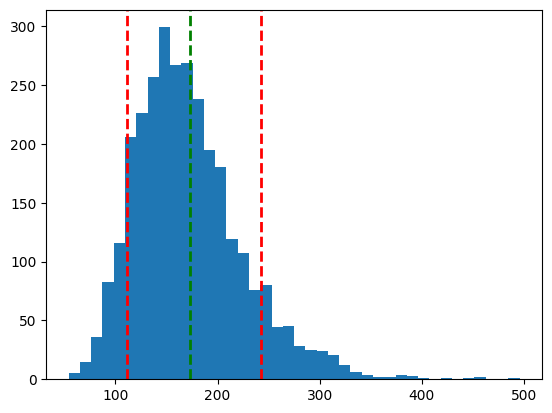

In [49]:
# Por último, podemos dividir a distribuição em percentis para nos ajudar
# a avaliar risco versus recompensa.

# Obtendo o top 10% dos resultados possíveis...
top_ten = np.percentile(closing_prices,100-10)

# Obtendo o bottom 10% dos resultados possíveis...
bottom_ten = np.percentile(closing_prices,10);

# Criando o histograma novamente:
plt.hist(closing_prices, bins = 40)

# Incluindo a linha dos top 10%:
plt.axvline(top_ten,color='r',linestyle='dashed',linewidth=2)

# Incluindo a linha dos bottom 10%:
plt.axvline(bottom_ten,color='r',linestyle='dashed',linewidth=2)

# Incluindo a linha do preço atual:
plt.axvline(apple['Adj Close'][-1],color='g', linestyle='dashed',linewidth=2)

plt.show()